Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


Saving WhatsApp Image 2025-08-25 at 11.44.06_1ef907ae.jpg to WhatsApp Image 2025-08-25 at 11.44.06_1ef907ae.jpg
Uploaded: dict_keys(['WhatsApp Image 2025-08-25 at 11.44.06_1ef907ae.jpg'])
Classes in model: {0: 'inner_dia', 1: 'outer_dia'}


Saving WhatsApp Image 2025-08-25 at 11.44.06_1ef907ae (1).jpg to WhatsApp Image 2025-08-25 at 11.44.06_1ef907ae (1).jpg
Measured Outer Dia (in): 11.5
Measured Inner Dia (in): 2.2222222222222223


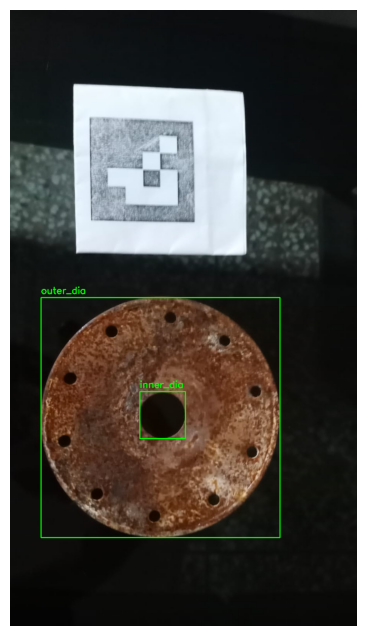

In [ ]:

import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
from google.colab import files

MODEL_PATH      = "best.pt"    # <-- upload your YOLO model
CLASSES         = ["outer_dia", "inner_dia"]   # must match training
KNOWN_OUTER_IN  = 11.5             # real outer diameter in inches (reference)


uploaded = files.upload()
print("Uploaded:", uploaded.keys())


model = YOLO(MODEL_PATH)
names = model.names
print("Classes in model:", names)


uploaded_img = files.upload()
img_path = list(uploaded_img.keys())[0]

frame = cv2.imread(img_path)


results = model(frame, verbose=False)
outer_px = None
inner_px = None

for r in results:
    for box in r.boxes:
        cls_id = int(box.cls[0])
        cls_name = names.get(cls_id, str(cls_id))

        if cls_name not in CLASSES:
            continue

        x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
        x1, y1, x2, y2 = map(int, (x1, y1, x2, y2))
        w_px = x2 - x1
        h_px = y2 - y1
        dia_px = (w_px + h_px) / 2  # average for circle

        if cls_name == "outer_dia":
            outer_px = dia_px
        elif cls_name == "inner_dia":
            inner_px = dia_px

        cv2.rectangle(frame, (x1,y1), (x2,y2), (0,255,0), 2)
        cv2.putText(frame, cls_name, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX,
                    0.8, (0,255,0), 2)

# ================== SCALE TO REAL SIZE ==================
if outer_px:
    px_to_inch = KNOWN_OUTER_IN / outer_px
    outer_in = outer_px * px_to_inch
    inner_in = inner_px * px_to_inch if inner_px else None
else:
    outer_in, inner_in = None, None

print("Measured Outer Dia (cm):", outer_in)
print("Measured Inner Dia (cm):", inner_in)

# ================== SHOW RESULT ==================
frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(8,8))
plt.imshow(frame_rgb)
plt.axis("off")
plt.show()


In [ ]:
import cv2
import numpy as np
from ultralytics import YOLO

# ================== CONFIG ==================
MODEL_PATH      = "/content/best.pt"
CLASSES         = ["outer_dia", "inner_dia"]
MARKER_SIZE_CM  = 5.0
ARUCO_DICT_ID   = cv2.aruco.DICT_4X4_50
ARUCO_ID        = 0
SMOOTH_ALPHA    = 0.25
VIDEO_PATH      = "/content/WhatsApp Video 2025-08-25 at 11.48.24_f08bf6db.mp4"   # uploaded input video
OUTPUT_PATH     = "/content/output.mp4"  # processed output video

# ================== LOAD YOLO ==================
model = YOLO(MODEL_PATH)
names = model.names

# ================== ARUCO ==================
aruco = cv2.aruco
aruco_dict = aruco.getPredefinedDictionary(ARUCO_DICT_ID)
aruco_params = cv2.aruco.DetectorParameters()

def aruco_cm_per_pixel(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    detector = cv2.aruco.ArucoDetector(aruco_dict, aruco_params)
    corners, ids, _ = detector.detectMarkers(gray)
    if ids is None:
        return None, None
    idx = None
    for i, idv in enumerate(ids.flatten()):
        if int(idv) == int(ARUCO_ID):
            idx = i
            break
    if idx is None:
        return None, None
    pts = corners[idx][0]
    px_side = np.mean([
        np.linalg.norm(pts[0] - pts[1]),
        np.linalg.norm(pts[1] - pts[2]),
        np.linalg.norm(pts[2] - pts[3]),
        np.linalg.norm(pts[3] - pts[0]),
    ])
    cm_per_px = MARKER_SIZE_CM / px_side
    return cm_per_px, pts

def draw_aruco(frame, pts):
    pts = pts.astype(int)
    for i in range(4):
        cv2.line(frame, tuple(pts[i]), tuple(pts[(i+1)%4]), (0,140,255), 2)
    cX, cY = np.mean(pts, axis=0).astype(int)
    cv2.circle(frame, (cX, cY), 3, (0,140,255), -1)

# ================== PROCESS VIDEO ==================
cap = cv2.VideoCapture(VIDEO_PATH)

# get video info for saving
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
fps = int(cap.get(cv2.CAP_PROP_FPS))
w   = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
h   = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
out = cv2.VideoWriter(OUTPUT_PATH, fourcc, fps, (w, h))

cm_per_px_smoothed = None

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # 1) ArUco calibration
    cm_per_px_new, aruco_pts = aruco_cm_per_pixel(frame)
    if cm_per_px_new is not None and 0.0001 < cm_per_px_new < 1.0:
        cm_per_px_smoothed = (
            cm_per_px_new if cm_per_px_smoothed is None
            else (1 - SMOOTH_ALPHA) * cm_per_px_smoothed + SMOOTH_ALPHA * cm_per_px_new
        )
        draw_aruco(frame, aruco_pts)
        cv2.putText(frame, f"Scale: {cm_per_px_smoothed*10:.2f} mm/px",
                    (12, 28), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,140,255), 2)
    else:
        cv2.putText(frame, "ArUco NOT visible",
                    (12, 28), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (40,40,255), 2)

    # 2) YOLO detection
    results = model(frame, verbose=False)
    for r in results:
        for box in r.boxes:
            cls_id = int(box.cls[0])
            cls_name = names.get(cls_id, str(cls_id))
            if cls_name not in CLASSES:
                continue
            x1, y1, x2, y2 = map(int, box.xyxy[0].cpu().numpy())
            w_px, h_px = x2 - x1, y2 - y1
            dia_px = (w_px + h_px) / 2
            if cm_per_px_smoothed is not None:
                dia_cm = dia_px * cm_per_px_smoothed
                dia_in = dia_cm / 2.54
                label = f"{cls_name}: {dia_in:.2f} in"
            else:
                label = f"{cls_name}: {dia_px}px"
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0,255,0), 2)
            cv2.putText(frame, label, (x1, max(20, y1-8)),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0), 2)

    # write to output file
    out.write(frame)

cap.release()
out.release()
print("Processing complete. Saved to:", OUTPUT_PATH)


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Processing complete. Saved to: /content/output.mp4
